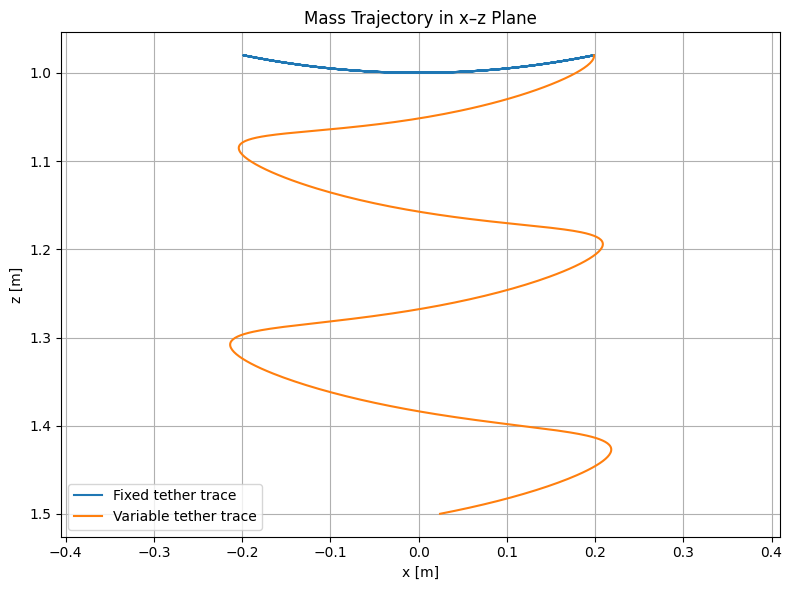

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81         # gravity [m/s²]
m = 1.0          # mass [kg]
ell0 = 1.0       # initial tether length [m]

# Fixed tether dynamics: [theta, theta_dot], u = [T]
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    T = u[0]
    theta_ddot = T / (m * ell0) - (g / ell0) * np.sin(theta)
    return np.array([theta_dot, theta_ddot])

# Variable tether dynamics: [theta, theta_dot, ell], u = [T, ell_dot]
def dynamics_variable(x, u):
    theta, theta_dot, ell = x
    T, ell_dot = u
    theta_ddot = T / (m * ell) - (g / ell) * np.sin(theta) - 2 * ell_dot * theta_dot / ell
    return np.array([theta_dot, theta_ddot, ell_dot])

# RK4 integrator
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + 0.5 * dt * k1, u)
    k3 = f(x + 0.5 * dt * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Simulation setup
dt = 0.01
T_sim = 5.0
N = int(T_sim / dt)
T_val = 0
ell_dot_val = 0.1

# Initial conditions
x_fixed = np.array([0.2, 0.0])
x_var = np.array([0.2, 0.0, ell0])

xs_fixed = [x_fixed]
xs_var = [x_var]

# Simulate both systems
for _ in range(N):
    u_fixed = np.array([T_val])
    u_var = np.array([T_val, ell_dot_val])
    x_fixed = rk4_step(dynamics_fixed, x_fixed, u_fixed, dt)
    x_var = rk4_step(dynamics_variable, x_var, u_var, dt)
    xs_fixed.append(x_fixed)
    xs_var.append(x_var)

xs_fixed = np.array(xs_fixed)
xs_var = np.array(xs_var)
time = np.linspace(0, T_sim, N+1)

# Convert to x–z coordinates
def get_xz_trace(theta_array, ell_array):
    x = ell_array * np.sin(theta_array)
    z = ell_array * np.cos(theta_array)
    return x, z

theta_fixed = xs_fixed[:, 0]
ell_fixed = ell0 * np.ones_like(theta_fixed)
x_fixed, z_fixed = get_xz_trace(theta_fixed, ell_fixed)

theta_var = xs_var[:, 0]
ell_var = xs_var[:, 2]
x_var, z_var = get_xz_trace(theta_var, ell_var)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_fixed, z_fixed, label='Fixed tether trace')
plt.plot(x_var, z_var, label='Variable tether trace')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.ylim(0, max(ell0, ell_var.max()) + 0.5)
plt.title('Mass Trajectory in x–z Plane')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optima

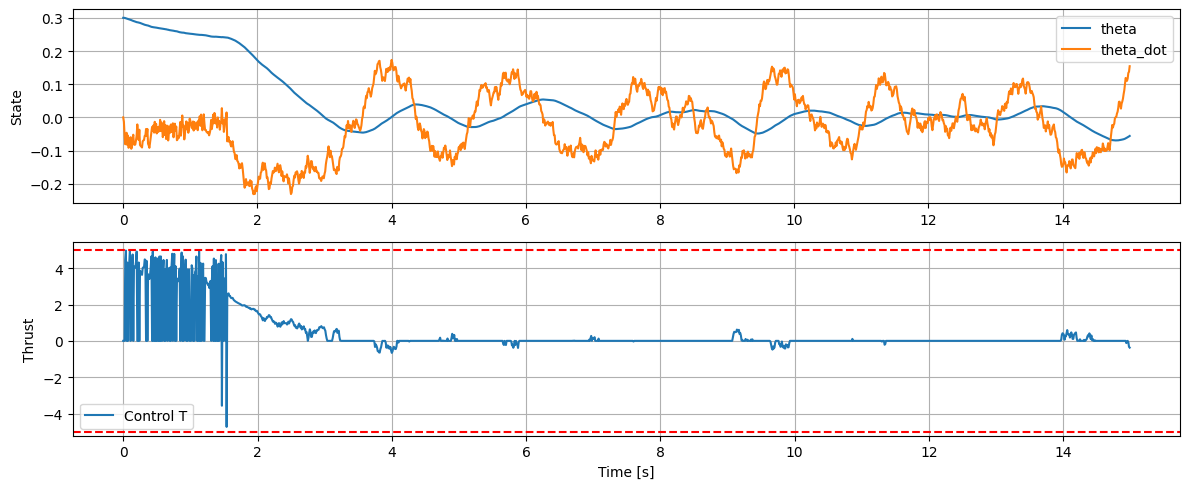

In [3]:
# Re-import after kernel reset
import numpy as np
import jax
import jax.numpy as jnp
import cvxpy as cp
import matplotlib.pyplot as plt

# Constants
g = 9.81
m = 1.0
ell = 1.0
c_d = 0.1
V_max = 20.0
T_max = 5.0
T_min = -5.0

omega0_sq = g / ell
eta = c_d * ell / m
b_val = 1 / (m * ell)
d_max = c_d / m * V_max

# Linear dynamics matrices
A = jnp.array([[0, 1], [-omega0_sq, eta]])
B = jnp.array([[0], [b_val]])
E = jnp.array([[0], [-1]])

# CBF parameters
P = jnp.array([[10.0, 0.0], [0.0, 1.0]])
epsilon = 0.5
alpha = lambda b: 1.0 * b  # Class K function

# Simulation parameters
dt = 0.01
T_sim = 15
N = int(T_sim / dt)

# Initial state
x = jnp.array([0.3, 0.0])
x_history = [x]
u_history = []

# QP definition
def solve_cbf_qp(x_np):
    x_cp = cp.Parameter(2)
    x_cp.value = np.array(x_np)

    u = cp.Variable()
    delta = cp.Variable(nonneg=True)

    # Compute terms
    xPx = cp.quad_form(x_cp, P)
    b_x = epsilon - xPx
    grad_b = -2 * P @ x_cp
    cbf_lhs = grad_b.T @ (A @ x_cp + B.flatten() * u)
    cbf_rhs = -alpha(b_x) + 2 * cp.abs(x_cp.T @ P @ E) * d_max + delta

    constraints = [
        cbf_lhs >= cbf_rhs,
        u >= T_min,
        u <= T_max
    ]

    objective = cp.Minimize((u)**2 + 1000 * cp.square(delta))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)

    return float(u.value if u.value is not None else 0.0)

# JAX dynamics
def dynamics(x, u, d):
    theta, theta_dot = x
    theta_ddot = -omega0_sq * theta + eta * theta_dot + b_val * u - d
    return jnp.array([theta_dot, theta_ddot])

# Simulate
for _ in range(N):
    wind_d = np.random.uniform(-d_max, d_max)
    u = solve_cbf_qp(x)
    x = x + dt * dynamics(x, u, wind_d)
    x_history.append(x)
    u_history.append(u)

x_history = np.array(x_history)
u_history = np.array(u_history)
t = np.linspace(0, T_sim, N + 1)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(t, x_history[:, 0], label='theta')
plt.plot(t, x_history[:, 1], label='theta_dot')
plt.ylabel("State")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u_history, label='Control T')
plt.axhline(T_max, color='r', linestyle='--')
plt.axhline(T_min, color='r', linestyle='--')
plt.ylabel("Thrust")
plt.xlabel("Time [s]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


## 1. Linearized Dynamics at Step $k$

Around the current state $x_k$ and input $u_k$, we form the first‐order Taylor expansion of the nonlinear plant
$
\dot x = f\bigl(x,u,d\bigr)
$

to obtain time‐varying matrices
$
\dot x \;\approx\; A_k\,x \;+\; B_k\,u \;+\; E_k\,d,
$
where
$
A_k = \frac{\partial f}{\partial x}\Bigl|_{(x_k,u_k,0)},\quad
B_k = \frac{\partial f}{\partial u}\Bigl|_{(x_k,u_k,0)},\quad
E_k = \frac{\partial f}{\partial d}\Bigl|_{(x_k,u_k,0)}.
$
Here $d$ is the bounded wind disturbance, $\|d\|\le d_{\max}$.

---

## 2. Hamilton–Jacobi Reachability

We seek the set of all initial states that can be driven into the shrinking angle bound
$
|\theta|\le s(t),
$
despite worst‐case wind.  Define the value function
$
V(x,t)
\;=\;
\inf_{u(\cdot)}\,\sup_{d(\cdot)}\,
\Bigl\{\,
\max_{\tau\in[t,T]}\bigl\|\theta(\tau)\bigr\|-s(\tau)
\Bigr\},
$
whose zero‐sublevel set is the safe tube.  $V$ satisfies the **linearized** Hamilton–Jacobi–Isaacs PDE backward in time:
$
\frac{\partial V}{\partial t}(x,t)
\;+\;
\underbrace{\max_{\|d\|\le d_{\max}}\;\min_{u_{\min}\le u\le u_{\max}}
    \nabla_x V^\top\bigl(A_kx + B_ku + E_kd\bigr)
}_{H\bigl(x,\nabla V,t\bigr)}
=0,
$
with terminal condition at $t=T$:
$
V(x,T) \;=\; \max\!\bigl(|\theta|-s(T),\,0\bigr).
$
Solving this PDE yields $V(x,0)\le0$, the set of all states safe over $[0,T]$.

---

## 3. Control‐Barrier Function (CBF)

Rather than solve the full PDE online, we use a CBF that enforces 
$\;|\theta|\le s(t)\;$ by keeping
$
h(x,t) \;=\; s(t)^2 \;-\;\theta^2 \;\ge\;0.
$

1. **Compute gradients**  
   $
   \nabla_x h(x,t) 
   = \begin{bmatrix}-2\theta & 0 & \cdots\end{bmatrix}, 
   \qquad
   \partial_t h(x,t)
   = 2\,s(t)\,\dot s(t).
   $

2. **Lie derivatives w.r.t. linear model**  
   $
   \dot h
   = \nabla_x h\,\bigl(A_kx + B_ku + E_kd\bigr)
     \;+\;\partial_t h.
   $
   Split into drift/control/disturbance:
   $
   L_f h = \nabla_x h\,A_kx,
   \quad
   L_g h = \nabla_x h\,B_k,
   \quad
   L_d h = \nabla_x h\,E_k.
   $

3. **Robust CBF constraint**  
   To guarantee $\dot h + \alpha\bigl(h\bigr)\ge0$ for all $\|d\|\le d_{\max}$, impose
   $
   L_f h(x_k) + L_g h(x_k)\,u 
   + \partial_t h(x_k)
   \;\ge\; -\alpha\bigl(h(x_k)\bigr)
          \;+\; \bigl|L_d h(x_k)\bigr|\,d_{\max}.
   $

Here $\alpha(r)$ is any class‐$\mathcal K$ function (e.g.\ $\alpha(r)=\gamma\,r$).

---

## 4. Quadratic Program (QP) Controller

At each step $k$, we solve for $u$ (and slack $\delta\ge0$):

$
\begin{aligned}
&\min_{u,\;\delta\ge0}
&&\bigl\|u - u_{\rm nom}(x_k)\bigr\|^2
   \;+\;\kappa\,\delta^2,\\
&\text{s.t.}
&&L_f h(x_k) 
  + L_g h(x_k)\,u 
  + \partial_t h(x_k)
  + \alpha\bigl(h(x_k)\bigr)
  \;\ge\;
  \bigl|L_d h(x_k)\bigr|\,d_{\max}
  - \delta,\\
&&&u_{\min}\le u\le u_{\max}.
\end{aligned}
$

Concretely, using the matrices:

1. Compute
   $
   L_f h(x_k) = \nabla_x h\,A_k\,x_k,\quad
   L_g h(x_k) = \nabla_x h\,B_k,\quad
   L_d h(x_k) = \nabla_x h\,E_k.
   $
2. Evaluate $\partial_t h(x_k)=2\,s_k\,\dot s_k$ and $h(x_k)=s_k^2-\theta_k^2$.
3. Plug into the linear inequality above.

Solving this small QP at each $t_k$ yields a **minimally invasive**, safe‐set preserving control law that guarantees $|\theta(t)|\le s(t)$ for all $t$, despite wind up to $d_{\max}$.


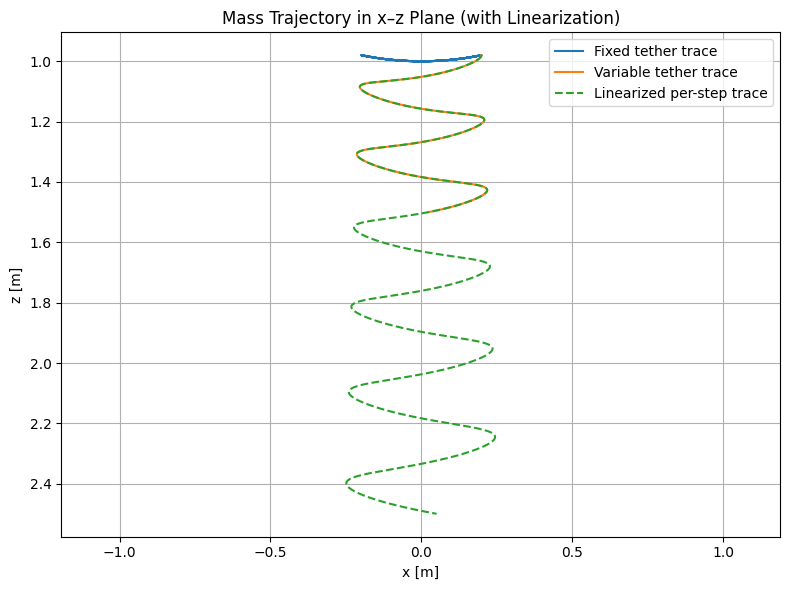

In [7]:
from dynamaxsys.utils import linearize  # use this now
import jax.numpy as jnp

# Time-varying input (optional): can keep fixed for now
def input_func(t):
    return np.array([0.0, 0.1])  # [T, ell_dot]

# Wind disturbance (can be added later if needed)
def disturbance_func(t):
    return 0.0  # or np.random.uniform(-V_max, V_max)

# Define nonlinear dynamics wrapper for linearization
def f_wrapped(x, u, t):
    theta, theta_dot, ell = x
    T, ell_dot = u
    d = 0.0  # zero wind for linearization
    theta_ddot = (1 / ell) * (
        T / (m * ell) - g * jnp.sin(theta) - 2 * ell_dot * theta_dot - (c_d / m) * d
    )
    return jnp.array([theta_dot, theta_ddot, ell_dot])

# Initialize
x_var_lin = np.array([0.2, 0.0, ell0])
xs_var_lin = [x_var_lin]
A_list, B_list = [], []

# Simulate with per-step linearization using dynamaxsys
for i in range(N):
    t = i * dt
    u = input_func(t)
    A, B, _ = linearize(f_wrapped, x_var_lin, u, t)
    A_list.append(A)
    B_list.append(B)
    x_var_lin = rk4_step(dynamics_variable, x_var_lin, u, dt)
    xs_var_lin.append(x_var_lin)

# Convert to trajectory
xs_var_lin = np.array(xs_var_lin)
theta_var_lin = xs_var_lin[:, 0]
ell_var_lin = xs_var_lin[:, 2]
x_lin, z_lin = get_xz_trace(theta_var_lin, ell_var_lin)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_fixed, z_fixed, label='Fixed tether trace')
plt.plot(x_var, z_var, label='Variable tether trace')
plt.plot(x_lin, z_lin, '--', label='Linearized per-step trace')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.ylim(0, max(ell0, ell_var_lin.max()) + 0.5)
plt.title('Mass Trajectory in x–z Plane (with Linearization)')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optima

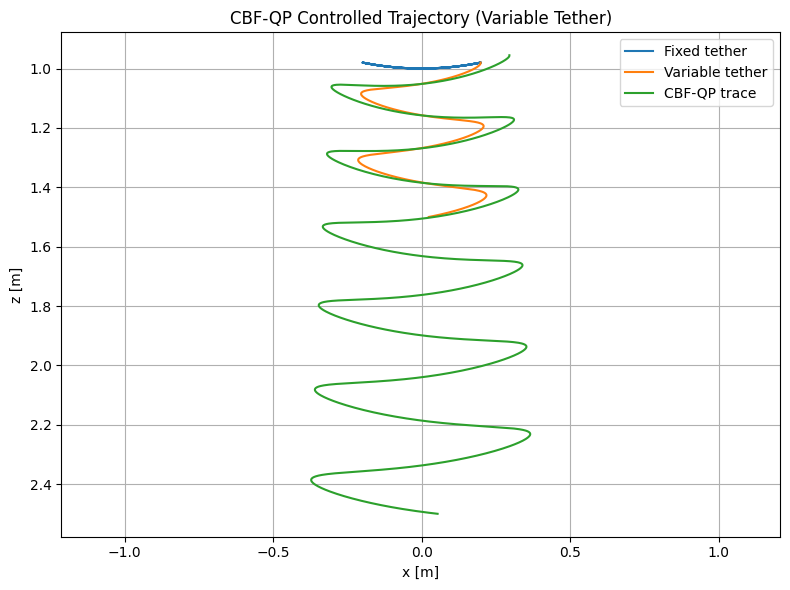

In [10]:
import cvxpy as cp

# Control bounds and constants
T_max = 50.0
T_min = -50.0
ldot_nom = 0.1  # fixed reeling speed
gamma = 1.0     # CBF alpha gain
P_mat = np.diag([10.0, 1.0, 1.0])  # for 3-state case (theta, theta_dot, ell)
epsilon = 0.5
d_max = 2.0  # wind bounds (can be adjusted)
penalty = 1000  # for slack variable

# CVXPY QP solver
def solve_cbf_qp_linearized(x, A, B, E):
    # Decision variables
    T = cp.Variable()
    delta = cp.Variable(nonneg=True)

    # Extract state deviation (around previous linearization point)
    delta_x = x - x_star  # x_star will be set at each step to previous state

    # Barrier function and gradient
    b_x = epsilon - cp.quad_form(delta_x, P_mat)
    grad_b = -2 * P_mat @ delta_x

    # Linearized dynamics f = A x + B u + E d
    cbf_lhs = grad_b.T @ (A @ delta_x + B * T)
    cbf_rhs = -gamma * b_x + 2 * cp.abs(grad_b.T @ E) * d_max + delta

    # Constraints
    constraints = [
        cbf_lhs >= cbf_rhs,
        T >= T_min,
        T <= T_max
    ]

    # Objective
    objective = cp.Minimize(cp.square(T) + penalty * cp.square(delta))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)

    return float(T.value if T.value is not None else 0.0)

# Simulate with CBFC QP applied at each step
x_cbf = np.array([0.3, 0.0, ell0])  # initial state
xs_cbf = [x_cbf.copy()]
u_cbf = []

for i in range(N):
    t = i * dt
    A = A_list[i]
    B = B_list[i]
    E = np.array([[0], [-c_d / (m * x_cbf[2])], [0]])  # disturbance direction depends on length
    x_star = x_cbf.copy()  # linearize around previous state

    T_cbf = solve_cbf_qp_linearized(x_cbf, A, B, E)
    u = np.array([T_cbf, ldot_nom])
    x_cbf = rk4_step(dynamics_variable, x_cbf, u, dt)
    xs_cbf.append(x_cbf.copy())
    u_cbf.append(T_cbf)

# Convert and plot
xs_cbf = np.array(xs_cbf)
theta_cbf = xs_cbf[:, 0]
ell_cbf = xs_cbf[:, 2]
x_cbf_xy, z_cbf = get_xz_trace(theta_cbf, ell_cbf)

plt.figure(figsize=(8, 6))
plt.plot(x_fixed, z_fixed, label='Fixed tether')
plt.plot(x_var, z_var, label='Variable tether')
plt.plot(x_cbf_xy, z_cbf, label='CBF-QP trace')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.ylim(0, max(ell0, ell_cbf.max()) + 0.5)
plt.title('CBF-QP Controlled Trajectory (Variable Tether)')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


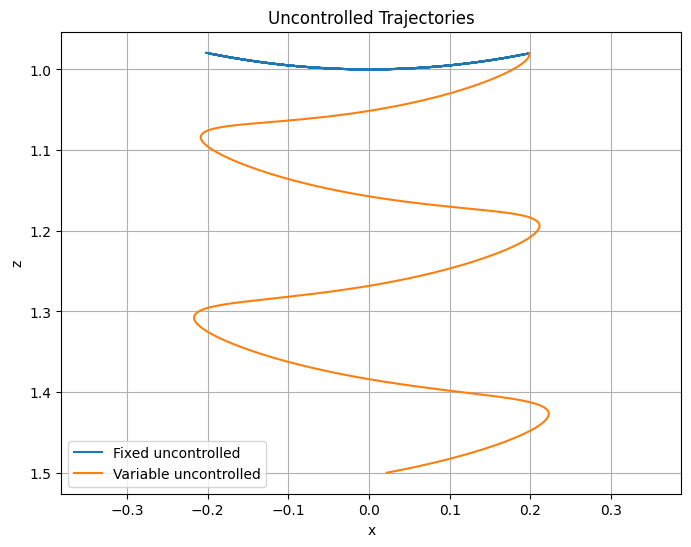

TypeError: unsupported operand type(s) for @: 'list' and 'list'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from dynamaxsys.utils import linearize
import cvxpy as cp

# ----------------------
# 1) CONFIG & DYNAMICS
# ----------------------
g = 9.81; m = 1.0; ell0 = 1.0; c_d = 0.1
V_max = 20.0; d_max = c_d/m * V_max
T_max = 50.0; T_min = -50.0; ldot_nom = 0.1
dt = 0.01; T_sim = 5.0; N = int(T_sim/dt)

# Fixed-length with wind
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    T = u[0]
    theta_ddot = (T/(m*ell0)
                  - (g/ell0)*np.sin(theta)
                  - (c_d/m)*d/ell0)
    return np.array([theta_dot, theta_ddot])

# Variable-length with wind
def dynamics_variable(x, u, d):
    theta, theta_dot, ell = x
    T, ell_dot = u
    theta_ddot = (1/ell)*( T/(m*ell)
                  - g*np.sin(theta)
                  - 2*ell_dot*theta_dot/ell
                  - (c_d/m)*d )
    return np.array([theta_dot, theta_ddot, ell_dot])

def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5*dt*k1, u, d)
    k3 = f(x + 0.5*dt*k2, u, d)
    k4 = f(x + dt*k3, u, d)
    return x + dt/6*(k1+2*k2+2*k3+k4)

def get_xz_trace(theta, ell):
    return ell*np.sin(theta), ell*np.cos(theta)

# ------------------------------
# 2) UNCONTROLLED SIMULATION
# ------------------------------
x_fixed = np.array([0.2,0.0]); xs_f=[x_fixed.copy()]
x_var   = np.array([0.2,0.0,ell0]); xs_v=[x_var.copy()]

for _ in range(N):
    d = np.random.uniform(-d_max, d_max)
    x_fixed = rk4_step(dynamics_fixed, x_fixed, [0.0], d, dt)
    x_var   = rk4_step(dynamics_variable, x_var, [0.0,ldot_nom], d, dt)
    xs_f.append(x_fixed.copy()); xs_v.append(x_var.copy())

xs_f=np.array(xs_f); xs_v=np.array(xs_v)
# Trajectories
x_f,z_f = get_xz_trace(xs_f[:,0], ell0)
x_v,z_v = get_xz_trace(xs_v[:,0], xs_v[:,2])

# Plot uncontrolled x-z
plt.figure(figsize=(8,6))
plt.plot(x_f,z_f,label='Fixed uncontrolled')
plt.plot(x_v,z_v,label='Variable uncontrolled')
plt.gca().invert_yaxis(); plt.axis('equal'); plt.grid(); plt.legend()
plt.title('Uncontrolled Trajectories'); plt.xlabel('x'); plt.ylabel('z')
plt.show()

# --------------------------------
# 3) PER-STEP LINEARIZATION
# --------------------------------
def f_wrapped(x,u,t):
    theta,theta_dot,ell = x
    T,ell_dot = u; d=0.0
    theta_dd = (1/ell)*(T/(m*ell) - g*jnp.sin(theta) -2*ell_dot*theta_dot/ell - (c_d/m)*d)
    return jnp.array([theta_dot, theta_dd, ell_dot])

x_lin=np.array([0.2,0.0,ell0])
A_list=[]; B_list=[]
for i in range(N):
    u_lin=[0.0,ldot_nom]
    A,B,_ = linearize(f_wrapped, x_lin, u_lin, i*dt)
    A_list.append(A); B_list.append(B)
    x_lin = rk4_step(dynamics_variable, x_lin, u_lin, 0.0, dt)
A_list=np.array(A_list); B_list=np.array(B_list)

# ------------------------------------
# 4) CBF-QP CONTROLLER
# ------------------------------------
# CBF params
gamma=1.0; epsilon=0.5; penalty=1e3
Pmat=np.diag([10.0,1.0,1.0])
K_theta=15.0; K_dtheta=5.0

def solve_cbf_qp(x,A,B,E):
    # extract B column for T
    B_u = B[:,0]; E_v=E[:,0]
    Tvar=cp.Variable(); delta=cp.Variable(nonneg=True)
    dx = x - np.array([0.0,0.0,ell0])
    # barrier
    bval = epsilon - cp.quad_form(dx, Pmat)
    gradb = -2*Pmat.dot(dx)
    # nominal PD
    Tnom = -K_theta*x[0] - K_dtheta*x[1]
    # constraint
    lhs = gradb.T @ (A.dot(dx) + B_u*Tvar)
    rhs = -gamma*bval + 2*cp.abs(gradb.T@E_v)*d_max + delta
    cons=[lhs>=rhs, Tvar>=T_min, Tvar<=T_max]
    obj = cp.Minimize((Tvar-Tnom)**2 + penalty*delta**2)
    cp.Problem(obj,cons).solve(solver=cp.OSQP)
    return float(Tvar.value if Tvar.value is not None else Tnom)

# Simulate CBF-QP
x_cbf = np.array([0.3,0.0,ell0])
xs_c=[]; u_hist=[]; theta_h=[]
for i in range(N):
    d=np.random.uniform(-d_max,d_max)
    A=A_list[i]; B=B_list[i]
    E=np.array([[0],[-c_d/(m*x_cbf[2])],[0]])
    xstar=x_cbf.copy()
    Tcbf = solve_cbf_qp(x_cbf,A,B,E)
    u=[Tcbf,ldot_nom]
    dx=dynamics_variable(x_cbf,u,d)
    x_cbf = x_cbf + dt*dx
    xs_c.append(x_cbf.copy()); u_hist.append(Tcbf); theta_h.append(x_cbf[0])

xs_c=np.array(xs_c); theta_h=np.array(theta_h)
ell_c=xs_c[:,2]; time=np.linspace(0,T_sim,N)

# Plot θ and T
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(time,theta_h,label='θ'); plt.axhline(0,ls='--',c='gray')
plt.ylabel('θ'); plt.grid(); plt.legend()
plt.subplot(2,1,2)
plt.plot(time,u_hist,label='T'); plt.axhline(T_max,ls='--',c='r')
plt.axhline(T_min,ls='--',c='r'); plt.ylabel('T'); plt.xlabel('t'); plt.grid(); plt.legend()
plt.show()

# Plot controlled x-z
x_c,z_c = get_xz_trace(theta_h, ell_c)
plt.figure(figsize=(8,6))
plt.plot(x_c,z_c,label='CBF-QP controlled')
plt.gca().invert_yaxis(); plt.axis('equal'); plt.grid(); plt.legend()
plt.title('Controlled x-z Trajectory'); plt.xlabel('x'); plt.ylabel('z')
plt.show()
